# Evaluation of Machine Learning Models for Sentiment Analysis

### Imports

In [24]:
import copy
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from tqdm import tqdm

# warnings.filterwarnings("ignore")

In [25]:
RF_N_ESTIMATORS = 50  # Random Forest trees
LR_MAX_ITER = 500  # Logistic Regression iterations
SVC_MAX_ITER = 100  # SVM iterations
DT_MAX_DEPTH = 5  # Decision Tree depth
CV_FOLDS = 3  # Cross-validation folds
MAX_FEATURES = 5000  # BoW features

## Preprocessing Steps

In [26]:
df = pd.read_csv("data/reviews_sample_processed.csv")

### Label Encoding

This step converts 'positive' and 'negative' labels into numerical values (0 and 1).

In [27]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])

In [28]:
print(
    f"Label encoding: {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}"
)

Label encoding: {'negative': np.int64(0), 'positive': np.int64(1)}


### Bag of Words (BoW) Matrix Creation

This step converts the text data into a numerical format based on frequency of words.

In [29]:
vectorizer = CountVectorizer(
    max_features=MAX_FEATURES,
    min_df=2,  # Ignore terms that appear in less than 2 documents
    max_df=0.95,  # Ignore terms that appear in more than 95% of documents
    stop_words="english",
)

X = vectorizer.fit_transform(df["text"])

In [30]:
print(f"BoW matrix shape: {X.shape}")

BoW matrix shape: (69903, 5000)


### Splitting the Data

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [32]:
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (55922, 5000)
Test set shape: (13981, 5000)


## Training and Evaluating Models

In [33]:
results = {}


def get_result(y_test, y_pred):
    return {
        "test_accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average="weighted"),
        "recall": recall_score(y_test, y_pred, average="weighted"),
        "f1_score": f1_score(y_test, y_pred, average="weighted"),
        "predictions": y_pred,
        "positive_precision": precision_score(
            y_test, y_pred, pos_label=1, average="binary"
        ),
        "positive_recall": recall_score(y_test, y_pred, pos_label=1, average="binary"),
        "positive_f1_score": f1_score(y_test, y_pred, pos_label=1, average="binary"),
        "negative_precision": precision_score(
            y_test, y_pred, pos_label=0, average="binary"
        ),
        "negative_recall": recall_score(y_test, y_pred, pos_label=0, average="binary"),
        "negative_f1_score": f1_score(y_test, y_pred, pos_label=0, average="binary"),
    }


base_classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42, max_depth=DT_MAX_DEPTH),
    "Logistic Regression": LogisticRegression(
        random_state=42, max_iter=LR_MAX_ITER, verbose=1
    ),
    "SVM": SVC(
        random_state=42,
        max_iter=SVC_MAX_ITER,
        probability=True,
        kernel="linear",
        verbose=True,
    ),
}

### Random Forest

In [34]:
start_time = time.time()

rf_clf = RandomForestClassifier(
    n_estimators=RF_N_ESTIMATORS, random_state=42, max_depth=DT_MAX_DEPTH, verbose=1
)

rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)

results["Random Forest"] = get_result(y_test, y_pred_rf)

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.3s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    0.0s finished


### Soft Voting (Averaged Voting)

In [35]:
soft_voting_clf = VotingClassifier(
    estimators=[
        ("dt", base_classifiers["Decision Tree"]),
        ("lr", base_classifiers["Logistic Regression"]),
        ("svm", base_classifiers["SVM"]),
    ],
    voting="soft",
)
soft_voting_clf.fit(X_train, y_train)
y_pred_soft = soft_voting_clf.predict(X_test)

results["Averaged Voting"] = get_result(y_test, y_pred_soft)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Hard Voting (Majority Voting)

In [36]:
hard_voting_clf = VotingClassifier(
    estimators=[
        ("dt", base_classifiers["Decision Tree"]),
        ("lr", base_classifiers["Logistic Regression"]),
        ("svm", base_classifiers["SVM"]),
    ],
    voting="hard",
)
hard_voting_clf.fit(X_train, y_train)
y_pred_hard = hard_voting_clf.predict(X_test)

results["Majority Voting"] = get_result(y_test, y_pred_hard)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Weighted Voting

In [37]:
cv_scores = {}
for name, clf in tqdm(base_classifiers.items(), desc="CV Scoring"):
    scores = cross_val_score(clf, X_train, y_train, cv=CV_FOLDS, scoring="accuracy")
    cv_scores[name] = scores.mean()

# Normalize weights
total_score = sum(cv_scores.values())
weights = [
    cv_scores["Decision Tree"] / total_score,
    cv_scores["Logistic Regression"] / total_score,
    cv_scores["SVM"] / total_score,
]

weighted_voting_clf = VotingClassifier(
    estimators=[
        ("dt", base_classifiers["Decision Tree"]),
        ("lr", base_classifiers["Logistic Regression"]),
        ("svm", base_classifiers["SVM"]),
    ],
    voting="soft",
    weights=weights,
)
weighted_voting_clf.fit(X_train, y_train)
y_pred_weighted = weighted_voting_clf.predict(X_test)

results["Weighted Voting"] = get_result(y_test, y_pred_weighted)

CV Scoring:  33%|███▎      | 1/3 [00:00<00:01,  1.78it/s][Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished
CV Scoring:  67%|██████▋   | 2/3 [00:01<00:00,  1.14it/s]

[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.703758, rho = 0.671195
nSV = 196, nBSV = 0
Total nSV = 196
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.229745, rho = 0.627930
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -9.900354, rho = 0.687802
nSV = 197, nBSV = 0
Total nSV = 197
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.835204, rho = 0.567349
nSV = 196, nBSV = 0
Total nSV = 196
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.716500, rho = 0.669582
nSV = 193, nBSV = 1
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.270682, rho = 0.644997
nSV = 198, nBSV = 0
Total nSV = 198


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.889357, rho = 0.906439
nSV = 197, nBSV = 0
Total nSV = 197
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.872053, rho = 0.818111
nSV = 197, nBSV = 0
Total nSV = 197
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.748964, rho = 0.908294
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.046676, rho = 1.013602
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.206369, rho = 1.244511
nSV = 191, nBSV = 0
Total nSV = 191
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.401859, rho = 0.715975
nSV = 198, nBSV = 0
Total nSV = 198


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.465139, rho = 0.933372
nSV = 196, nBSV = 0
Total nSV = 196
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.939473, rho = 0.887560
nSV = 196, nBSV = 1
Total nSV = 196
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.922568, rho = 1.102556
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.895251, rho = 1.158251
nSV = 192, nBSV = 1
Total nSV = 192
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.907891, rho = 0.950398
nSV = 197, nBSV = 0
Total nSV = 197
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.674907, rho = 0.651152
nSV = 199, nBSV = 0
Total nSV = 199


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
CV Scoring: 100%|██████████| 3/3 [00:35<00:00, 11.85s/it]
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


### Q-Learning in Ensemble Learning

This is the method provided by the paper. We use Q-learning method in updating the weights of the classifiers in the ensemble.

In [40]:
class StatelessQLearningEnsemble:
    def __init__(
        self,
        base_classifiers,
        gamma=0.95,
        tau_initial=1.0,
        tau_min=0.01,
        alpha=0.1,
        max_episodes=100,
    ):
        self.base_classifiers = base_classifiers
        self.classifier_names = list(base_classifiers.keys())
        self.n_actions = len(base_classifiers)

        # Q-learning parameters
        self.gamma = gamma
        self.tau = tau_initial
        self.tau_min = tau_min
        self.alpha = alpha
        self.max_episodes = max_episodes

        self.Q_table = {}

        self.trained_classifiers = {}

    def _get_state_key(self, x):
        return tuple(np.round(x, decimals=2))

    def _get_sample(self, X, index):
        if sparse.issparse(X):
            return X[index].toarray().flatten()
        else:
            return X[index]

    def _boltzmann_action_selection(self, state_key):
        if state_key not in self.Q_table:
            self.Q_table[state_key] = np.zeros(self.n_actions)

        Q_values = self.Q_table[state_key]

        # Boltzmann equation: p(s_i, a) = e^(Q(s_i,a)/τ) / Σ_a∈A e^(Q(s_i,a)/τ)
        exp_values = np.exp(Q_values / max(self.tau, self.tau_min))
        probabilities = exp_values / np.sum(exp_values)

        action = np.random.choice(self.n_actions, p=probabilities)
        return action

    def _calculate_reward(self, classifier_name, X_sample, y_sample):
        if classifier_name not in self.trained_classifiers:
            return 0

        pred = self.trained_classifiers[classifier_name].predict(
            X_sample.reshape(1, -1)
        )
        reward = 1.0 if pred[0] == y_sample else 0.0
        return reward

    def _update_q_table(self, state_key, action, reward):
        if state_key not in self.Q_table:
            self.Q_table[state_key] = np.zeros(self.n_actions)

        # Q_new(a) = (1-α)Q(a) + α[r + γ * max_a Q(a')]
        current_q = self.Q_table[state_key][action]
        max_future_q = np.max(self.Q_table[state_key])

        new_q = (1 - self.alpha) * current_q + self.alpha * (
            reward + self.gamma * max_future_q
        )
        self.Q_table[state_key][action] = new_q

    def fit(self, X_train, y_train):
        for name, classifier in self.base_classifiers.items():
            self.trained_classifiers[name] = copy.deepcopy(classifier)
            self.trained_classifiers[name].fit(X_train, y_train)

        n_samples = X_train.shape[0]

        # Q-learning component (Algorithm 2)
        for episode in tqdm(range(self.max_episodes)):
            for i in range(n_samples):
                X_sample = self._get_sample(X_train, i)
                state_key = self._get_state_key(X_sample)

                # Select action using Boltzmann equation
                action = self._boltzmann_action_selection(state_key)
                classifier_name = self.classifier_names[action]

                # Execute action and observe reward
                reward = self._calculate_reward(classifier_name, X_sample, y_train[i])

                # Update Q-table
                self._update_q_table(state_key, action, reward)

            # Scale down temperature
            self.tau = max(self.tau * 0.99, self.tau_min)

    def predict(self, X_test):
        predictions = []
        n_test_samples = X_test.shape[0]

        for i in range(n_test_samples):
            X_sample = self._get_sample(X_test, i)
            state_key = self._get_state_key(X_sample)

            if state_key in self.Q_table:
                action = np.argmax(self.Q_table[state_key])
            else:
                action = np.random.choice(self.n_actions)

            classifier_name = self.classifier_names[action]

            if classifier_name in self.trained_classifiers:
                if X_sample.ndim == 1:
                    X_sample = X_sample.reshape(1, -1)

                pred = self.trained_classifiers[classifier_name].predict(X_sample)
                predictions.append(pred[0])
            else:
                all_preds = []
                for clf_name, clf in self.trained_classifiers.items():
                    if X_sample.ndim == 1:
                        X_sample = X_sample.reshape(1, -1)
                    pred = clf.predict(X_sample)
                    all_preds.append(pred[0])
                predictions.append(max(set(all_preds), key=all_preds.count))

        return np.array(predictions)

In [42]:
ql_ensemble = StatelessQLearningEnsemble(
    base_classifiers=base_classifiers,
    gamma=0.95,
    tau_initial=1.0,
    tau_min=0.01,
    alpha=0.1,
    max_episodes=3,
)

ql_ensemble.fit(X_train, y_train)
y_pred_ql = ql_ensemble.predict(X_test)

results["Q-Learning Ensemble"] = get_result(y_test, y_pred_ql)

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.5s finished


[LibSVM]WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.025088, rho = 0.706018
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -8.606189, rho = 0.678301
nSV = 199, nBSV = 0
Total nSV = 199
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.082056, rho = 0.940233
nSV = 195, nBSV = 0
Total nSV = 195
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.935078, rho = 0.899133
nSV = 193, nBSV = 0
Total nSV = 193
WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.967616, rho = 0.380767
nSV = 194, nBSV = 0
Total nSV = 194


/Users/amir/Documents/personal/DataMiningProject/.venv/lib/python3.11/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


WARN: libsvm Solver reached max_iter
optimization finished, #iter = 100
obj = -7.822860, rho = 0.983328
nSV = 198, nBSV = 0
Total nSV = 198


100%|██████████| 3/3 [01:46<00:00, 35.49s/it]


## Results Summary and Visualization

In [44]:
results_df = pd.DataFrame(results).T
results_df = results_df[
    [
        "test_accuracy",
        "precision",
        "recall",
        "f1_score",
        "positive_precision",
        "positive_recall",
        "positive_f1_score",
        "negative_precision",
        "negative_recall",
        "negative_f1_score",
    ]
]
results_df.columns = [
    "Accuracy",
    "Precision",
    "Recall",
    "F1-Score",
    "Positive Precision",
    "Positive Recall",
    "Positive F1-Score",
    "Negative Precision",
    "Negative Recall",
    "Negative F1-Score",
]
results_df = results_df.reset_index().rename(columns={"index": "Model"})
results_df = results_df.round(4)

In [45]:
results_df

,Model,Accuracy,Precision,Recall,F1-Score,Positive Precision,Positive Recall,Positive F1-Score,Negative Precision,Negative Recall,Negative F1-Score
0,Random Forest,0.689793,0.778217,0.689793,0.580932,0.684268,0.999148,0.812259,0.97037,0.057068,0.107797
1,Averaged Voting,0.855089,0.865139,0.855089,0.845702,0.835826,0.975932,0.900462,0.925091,0.607929,0.733701
2,Majority Voting,0.773121,0.792341,0.773121,0.741599,0.758738,0.970927,0.851817,0.861069,0.368547,0.516168
3,Weighted Voting,0.870539,0.875902,0.870539,0.864377,0.856203,0.970181,0.909636,0.916193,0.666739,0.77181
4,Q-Learning Ensemble,0.76604,0.762983,0.76604,0.745794,0.77025,0.928647,0.842065,0.74812,0.433457,0.54889


### Plots

#### Confusion Matrices

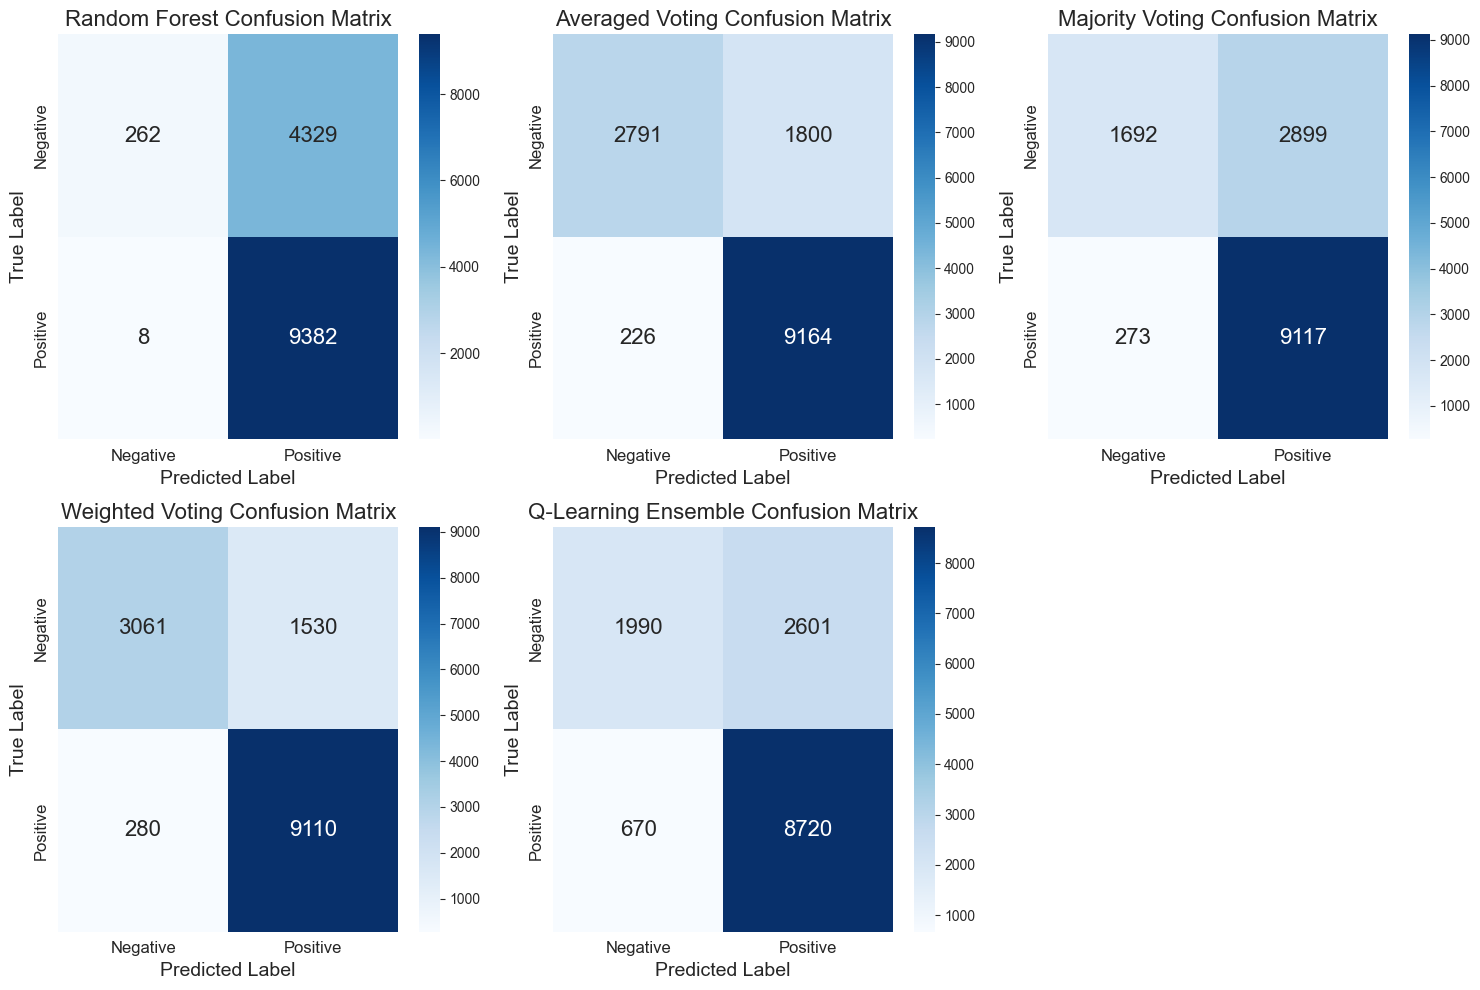

In [46]:
n_models = len(results)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))

if n_rows == 1:
    axes = axes.reshape(1, -1)
axes_flat = axes.flatten()

for i, (model_name, result) in enumerate(results.items()):
    ax = axes_flat[i]
    cm = confusion_matrix(y_test, result["predictions"])
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        annot_kws={"size": 16},
    )
    ax.set_title(f"{model_name} Confusion Matrix", fontsize=16)
    ax.set_xlabel("Predicted Label", fontsize=14)
    ax.set_ylabel("True Label", fontsize=14)
    ax.set_xticklabels(["Negative", "Positive"], fontsize=12)
    ax.set_yticklabels(["Negative", "Positive"], fontsize=12)

# Hide empty subplots if any
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

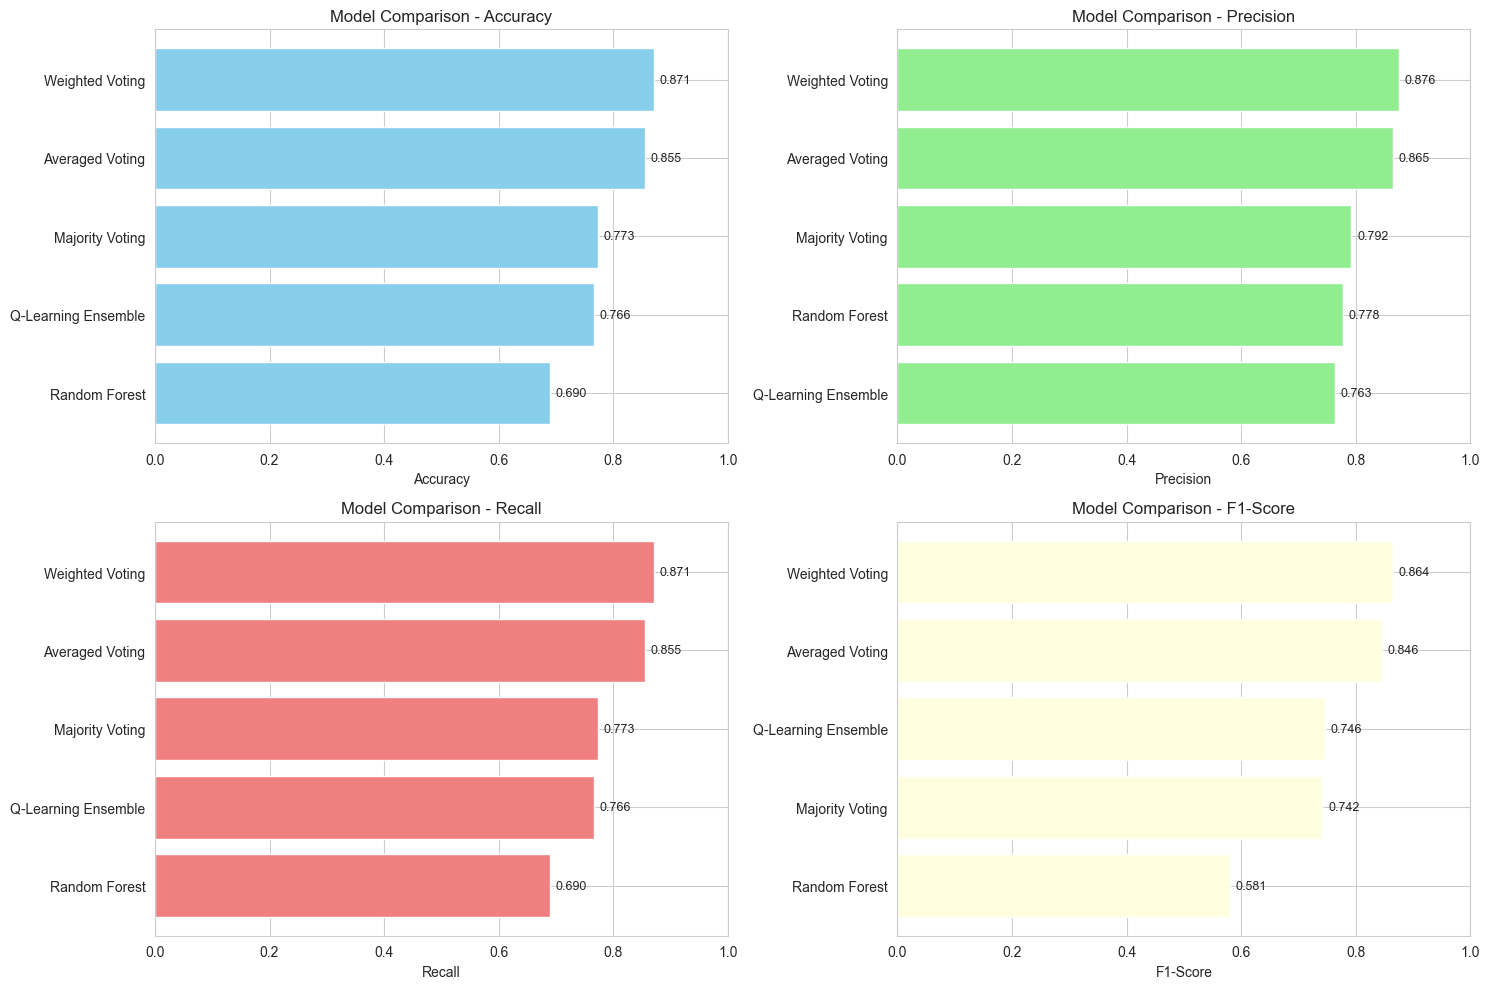

In [54]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
colors = ["skyblue", "lightgreen", "lightcoral", "lightyellow"]

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]

    sorted_data = results_df.sort_values(metric, ascending=True)

    bars = ax.barh(range(len(sorted_data)), sorted_data[metric], color=colors[i])
    ax.set_yticks(range(len(sorted_data)))
    ax.set_yticklabels(sorted_data["Model"])
    ax.set_xlabel(metric)
    ax.set_title(f"Model Comparison - {metric}")
    ax.set_xlim(0, 1)

    # Add value labels on bars
    for j, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(
            width + 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{width:.3f}",
            ha="left",
            va="center",
            fontsize=9,
        )

plt.tight_layout()
plt.show()